In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import time #to delay exectutions

import cmdstanpy
import arviz as az
az.style.use('arviz-darkgrid')

from parse_csv import parse_csv
import ComputeInfoC as CIC

/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.39ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.2.1pop0-1628521831-21.10-5dbe6cf is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
cwd = os.getcwd()
stan_directory = '~/.cmdstan/cmdstan-2.29.2'

## Generate data

In [3]:
np.random.seed(0)

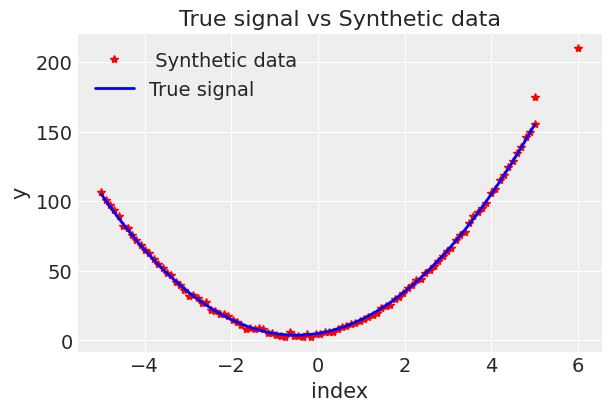

In [4]:
beta12 = 5
beta11= 5
beta10=5
sigma=1


nt = 100
t = np.linspace(-5, 5, nt)
y = beta12*(t**2)+ beta11*t + beta10

y_model = y + sigma * np.random.randn(y.size)

nt_outl = 2
t_outl = np.linspace(5, 6, nt_outl)
y_outl = 35 * t_outl

nt_obs = nt + nt_outl
t_obs = np.concatenate((t,t_outl), axis=0)
yobs = np.concatenate((y_model,y_outl), axis=0)

plt.figure(figsize=(6, 4))
plt.plot(t_obs, yobs,'r*', label=' Synthetic data' )
plt.plot(t, y, color='b', linewidth=2.0, label='True signal')
plt.xlabel("index")
plt.ylabel("y")
plt.title('True signal vs Synthetic data')
plt.legend()
plt.show() 

## Save data

In [5]:
data_dirname = 'poly_data_file'
data_filename = 'poly_data'
! mkdir -p  $data_dirname

In [6]:
data_dict = {'nt' : nt_obs, 't' : t_obs.tolist(), 'yobs' : yobs.tolist()}

data_as_json = json.dumps(data_dict, indent = 4)
with open(data_dirname + '/' + data_filename + '.json', 'w') as outfile:
    outfile.write(data_as_json)

In [7]:
! mkdir -p output
output_foldername = 'output'

## Order 1 regression 

In [8]:
models_dirname = 'models'
models_dirpath = cwd + '/' + models_dirname
order1_model = 'order1_model'
! cd $stan_directory/ && make $models_dirpath/$order1_model && cd $cwd

make: '/home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order1_model' is up to date.


In [9]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=500
warm_iter=500

model=order1_model
data_input=poly_data_file/poly_data.json
data_output=output_${alg}_${model}

mkdir -p ./output/${data_output}


for i in `seq 4`
do
    ./models/$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=./${data_input}\
        output file=output/${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> output/${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [10]:
output_order1_dirname = 'output_hmc_' + 'order1_model'
output_order1_dirpath = output_foldername + '/' + output_order1_dirname
order1_output_filename = 'output_hmc_order1_model_'

In [11]:
#wait and check: (Total)
time.sleep(5) #5 seconds sleep
!tail -n2 $output_order1_dirpath/*out

==> output/output_hmc_order1_model/output_hmc_order1_model_1.out <==
               0.285 seconds (Total)


==> output/output_hmc_order1_model/output_hmc_order1_model_2.out <==
               0.268 seconds (Total)


==> output/output_hmc_order1_model/output_hmc_order1_model_3.out <==
               0.258 seconds (Total)


==> output/output_hmc_order1_model/output_hmc_order1_model_4.out <==
               0.248 seconds (Total)



In [12]:
! $stan_directory/bin/stansummary $output_order1_dirpath/output_hmc_order1_model_*.csv

Inference for Stan model: order1_model_model
4 chains: each with iter=(500,500,500,500); warmup=(0,0,0,0); thin=(1,1,1,1); 2000 iterations saved.

Warmup took (0.17, 0.15, 0.14, 0.13) seconds, 0.58 seconds total
Sampling took (0.12, 0.12, 0.12, 0.12) seconds, 0.48 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat

lp__            -428  4.7e-02     1.3   -431  -428  -427      706     1470      1.0
accept_stat__   0.99  3.0e-04   0.012   0.97  1.00   1.0  1.7e+03  3.5e+03  1.0e+00
stepsize__      0.28  6.9e-04   0.022   0.25  0.29  0.31  1.0e+03  2.1e+03  3.7e+13
treedepth__      3.4  3.6e-02    0.63    2.0   3.0   4.0  3.1e+02  6.4e+02  1.0e+00
n_leapfrog__      12  4.6e-01     4.1    7.0    15    15  7.7e+01  1.6e+02  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__         430  6.8e-02     1.7    427   429   433  6.6e+02  1.4e+03  1.0e+00

p[1]              49  1.1e-01     4.2     42  

In [13]:
data_filepath = data_dirname + '/' + data_filename + '.json'
#Load the cmdstanpy output as an arviz.InferenceData object
output1 = az.from_cmdstan(posterior=output_order1_dirpath + '/' + order1_output_filename + '*'  + '.csv',
                          posterior_predictive='y_rep',
                          log_likelihood='log_lik',
                          observed_data=data_filepath, observed_data_var=['yobs'],
                          constant_data=data_filepath, constant_data_var=['t'])
output1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_uti

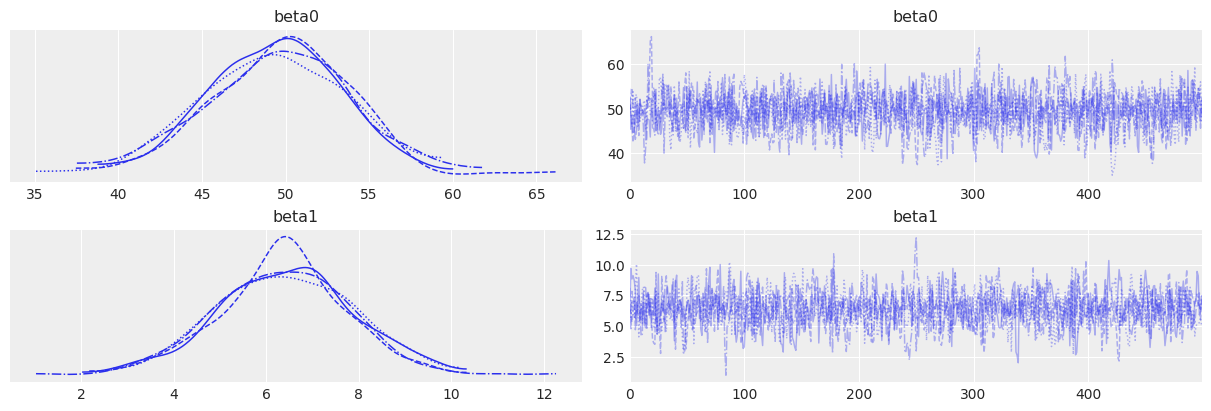

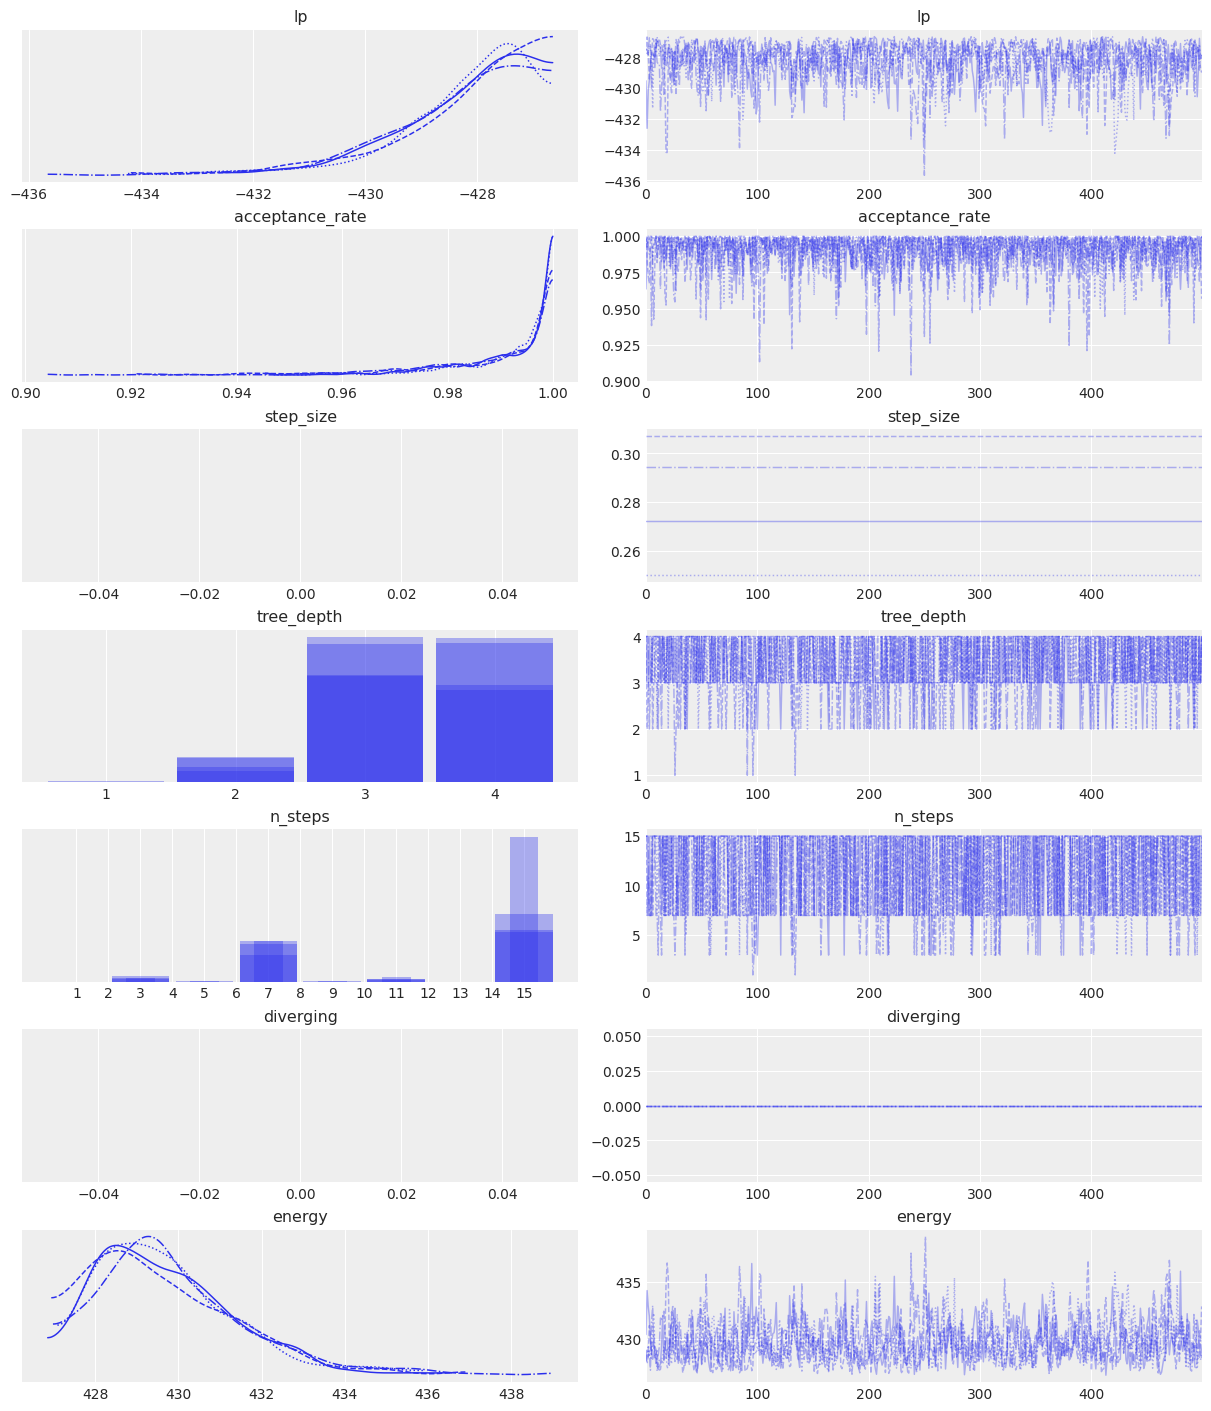

In [14]:
az.plot_trace(output1.posterior, var_names=['beta0', 'beta1']);
az.plot_trace(output1.sample_stats);

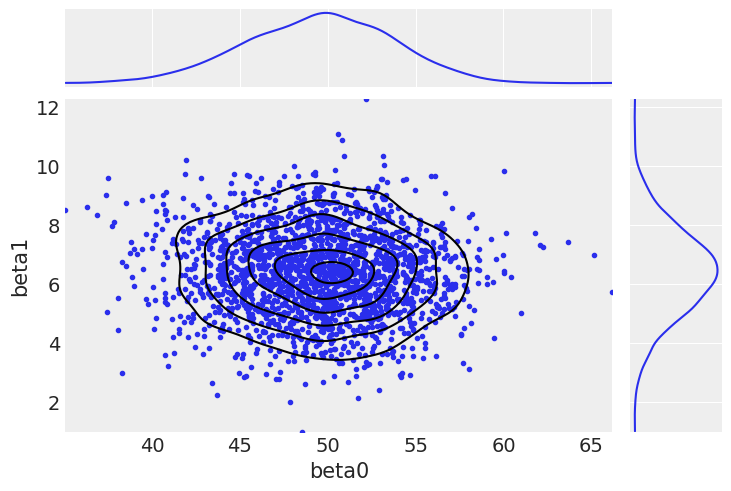

In [15]:
az.plot_pair(output1, var_names=['beta0', 'beta1'], kind=["scatter", "kde"], marginals=True);

/home/tng/.local/lib/python3.9/site-packages/arviz/plots/lmplot.py:214: UserWarning: y_hat not found in posterior_predictive
  warnings.warn("y_hat not found in posterior_predictive", UserWarning)
/home/tng/.local/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


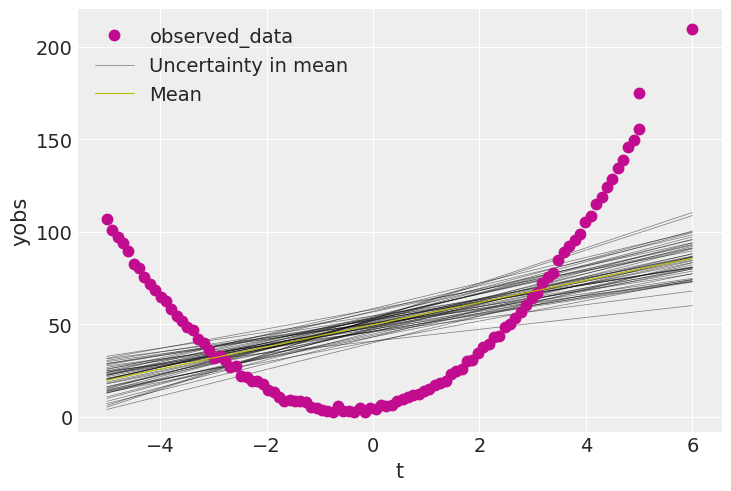

In [16]:
output1.posterior['y_model'] = output1.posterior['beta0'] + \
    output1.posterior['beta1'] * output1.constant_data['t']
az.plot_lm(idata=output1, y='yobs', x='t', y_model='y_model');

(500, 102)


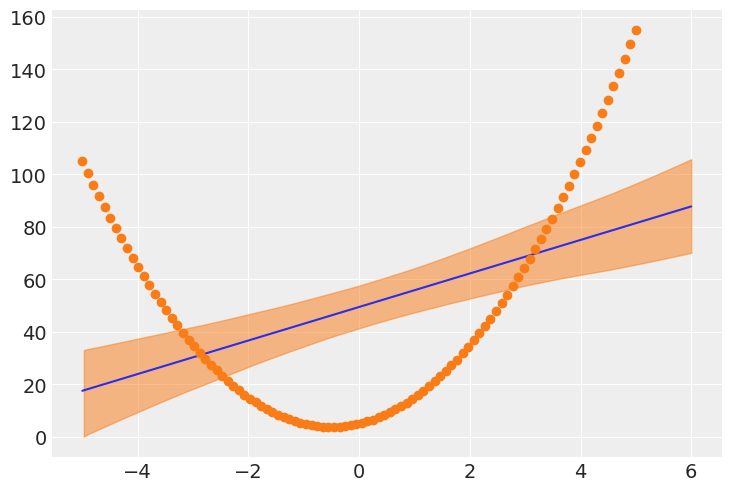

In [17]:
mean_chain = output1.posterior['y_model'].mean(axis=0)
print(mean_chain.shape)
az.plot_hdi(x=output1.constant_data['t'], y=output1.posterior['y_model'], hdi_prob=0.95)
plt.plot(output1.constant_data['t'], mean_chain.mean(axis=0))
plt.plot(t, y, 'o')

## Order 2 regression

In [18]:
order2_model = 'order2_model'
! cd $stan_directory/ && make $models_dirpath/$order2_model && cd $cwd

make: '/home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order2_model' is up to date.


In [19]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=500
warm_iter=500

model=order2_model
data_input=poly_data_file/poly_data.json
data_output=output_${alg}_${model}

mkdir -p ./output/${data_output}


for i in `seq 4`
do
    ./models/$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=./${data_input}\
        output file=output/${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> output/${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [20]:
output_order2_dirname = 'output_hmc_' + 'order2_model'
output_order2_dirpath = output_foldername + '/' + output_order2_dirname
order2_output_filename = 'output_hmc_order2_model_'

In [21]:
#wait and check: (Total)
time.sleep(5) #5 seconds sleep
!tail -n2 $output_order2_dirpath/*out

==> output/output_hmc_order2_model/output_hmc_order2_model_1.out <==
               0.405 seconds (Total)


==> output/output_hmc_order2_model/output_hmc_order2_model_2.out <==
               0.342 seconds (Total)


==> output/output_hmc_order2_model/output_hmc_order2_model_3.out <==
               0.311 seconds (Total)


==> output/output_hmc_order2_model/output_hmc_order2_model_4.out <==
               0.439 seconds (Total)



In [22]:
! $stan_directory/bin/stansummary $output_order2_dirpath/output_hmc_order2_model_*.csv

Inference for Stan model: order2_model_model
4 chains: each with iter=(500,500,500,500); warmup=(0,0,0,0); thin=(1,1,1,1); 2000 iterations saved.

Warmup took (0.22, 0.15, 0.13, 0.22) seconds, 0.71 seconds total
Sampling took (0.19, 0.20, 0.18, 0.22) seconds, 0.78 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat

lp__            -132  5.0e-02     1.4   -135  -132  -130      797     1017      1.0
accept_stat__   0.99  1.2e-03   0.011   0.97  1.00  1.00  7.3e+01  9.3e+01  1.0e+00
stepsize__      0.17  2.0e-02   0.029   0.13  0.19  0.20  2.0e+00  2.6e+00  9.3e+13
treedepth__      4.1  1.4e-01    0.62    3.0   4.0   5.0  2.1e+01  2.7e+01  1.1e+00
n_leapfrog__      21  2.1e+00     8.9    7.0    15    31  1.8e+01  2.3e+01  1.1e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__         134  7.5e-02     2.1    131   134   138  7.5e+02  9.5e+02  1.0e+00

p[1]             4.6  9.9e-03    0.31    4.1  

In [23]:
#Load the cmdstanpy output as an arviz.InferenceData object
output2 = az.from_cmdstan(posterior=output_order2_dirpath + '/' + order2_output_filename + '*'  + '.csv',
                          posterior_predictive='y_rep',
                          observed_data=data_filepath, observed_data_var=['y'],
                          constant_data=data_filepath, constant_data_var=['t'])
output2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

(500, 102)


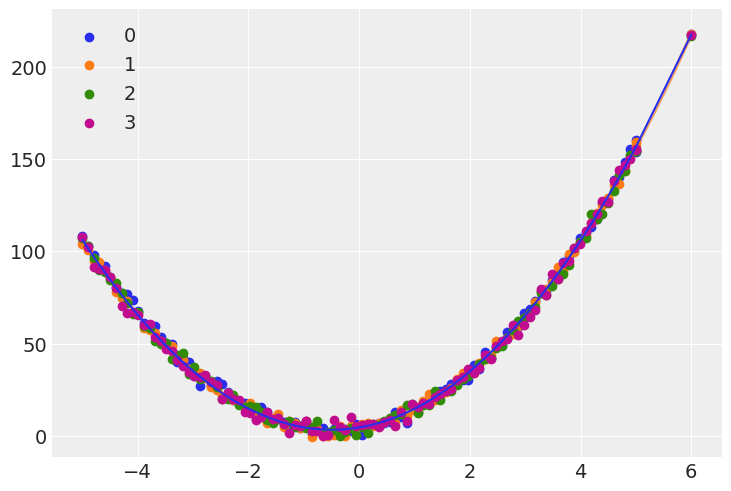

In [24]:
output2.posterior['y_model'] = output2.posterior['beta0'] + \
    output2.posterior['beta1'] * output2.constant_data['t'] + \
    output2.posterior['beta2'] * output2.constant_data['t']**2
mean_chain = output2.posterior['y_model'].mean(axis=0)
print(mean_chain.shape)
az.plot_hdi(x=output2.constant_data['t'], y=output2.posterior['y_model'], hdi_prob=0.95)
plt.plot(output2.constant_data['t'], mean_chain.mean(axis=0))

for ichain in range(4) :
    plt.scatter(output2.constant_data['t'], output2.posterior_predictive['y_rep'][ichain][0], label=str(ichain))
plt.legend()
plt.show()

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_uti

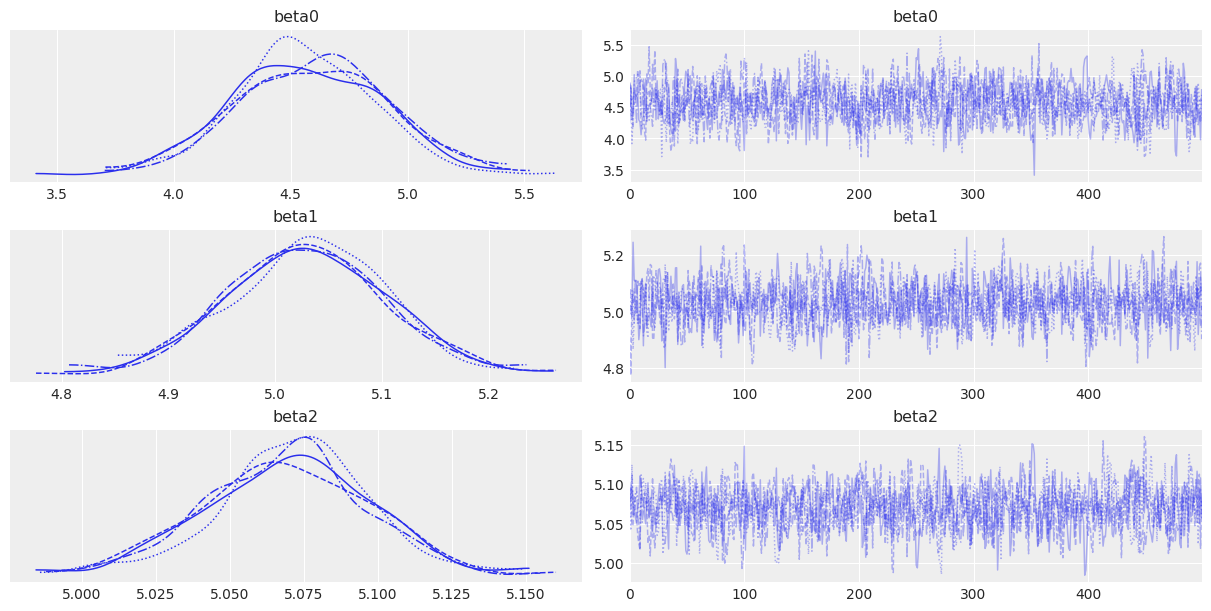

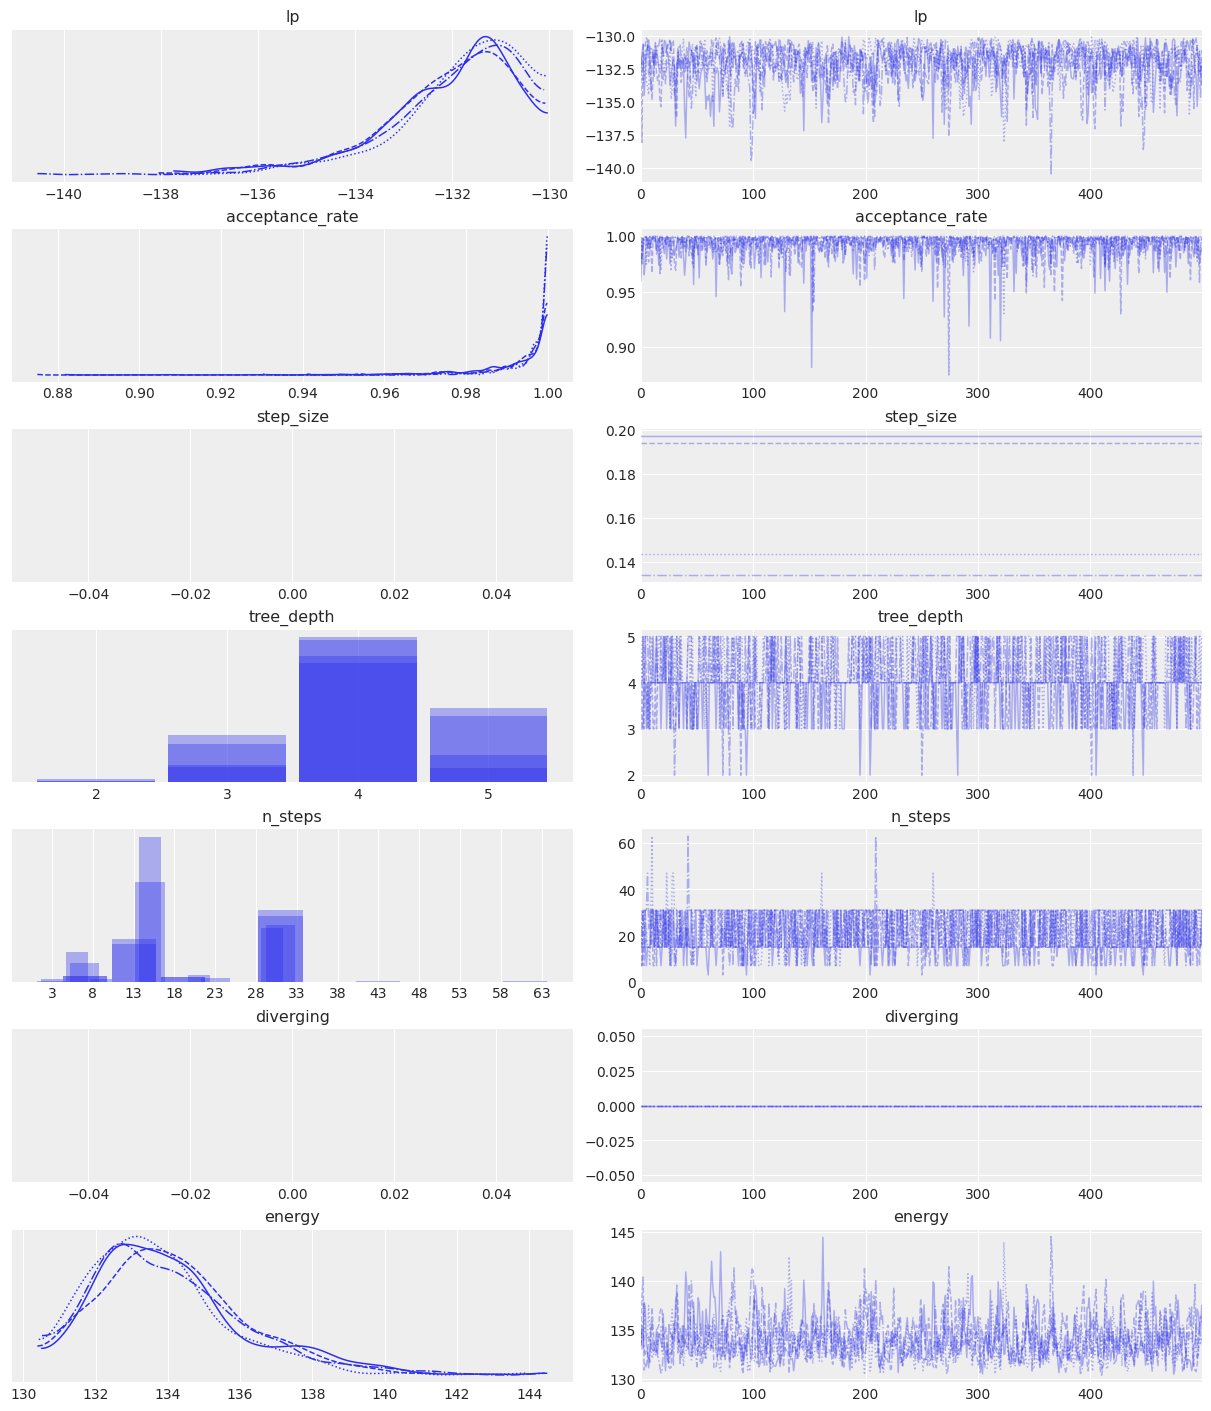

In [25]:
az.plot_trace(output2.posterior, var_names=['beta0', 'beta1', 'beta2']);
az.plot_trace(output2.sample_stats);

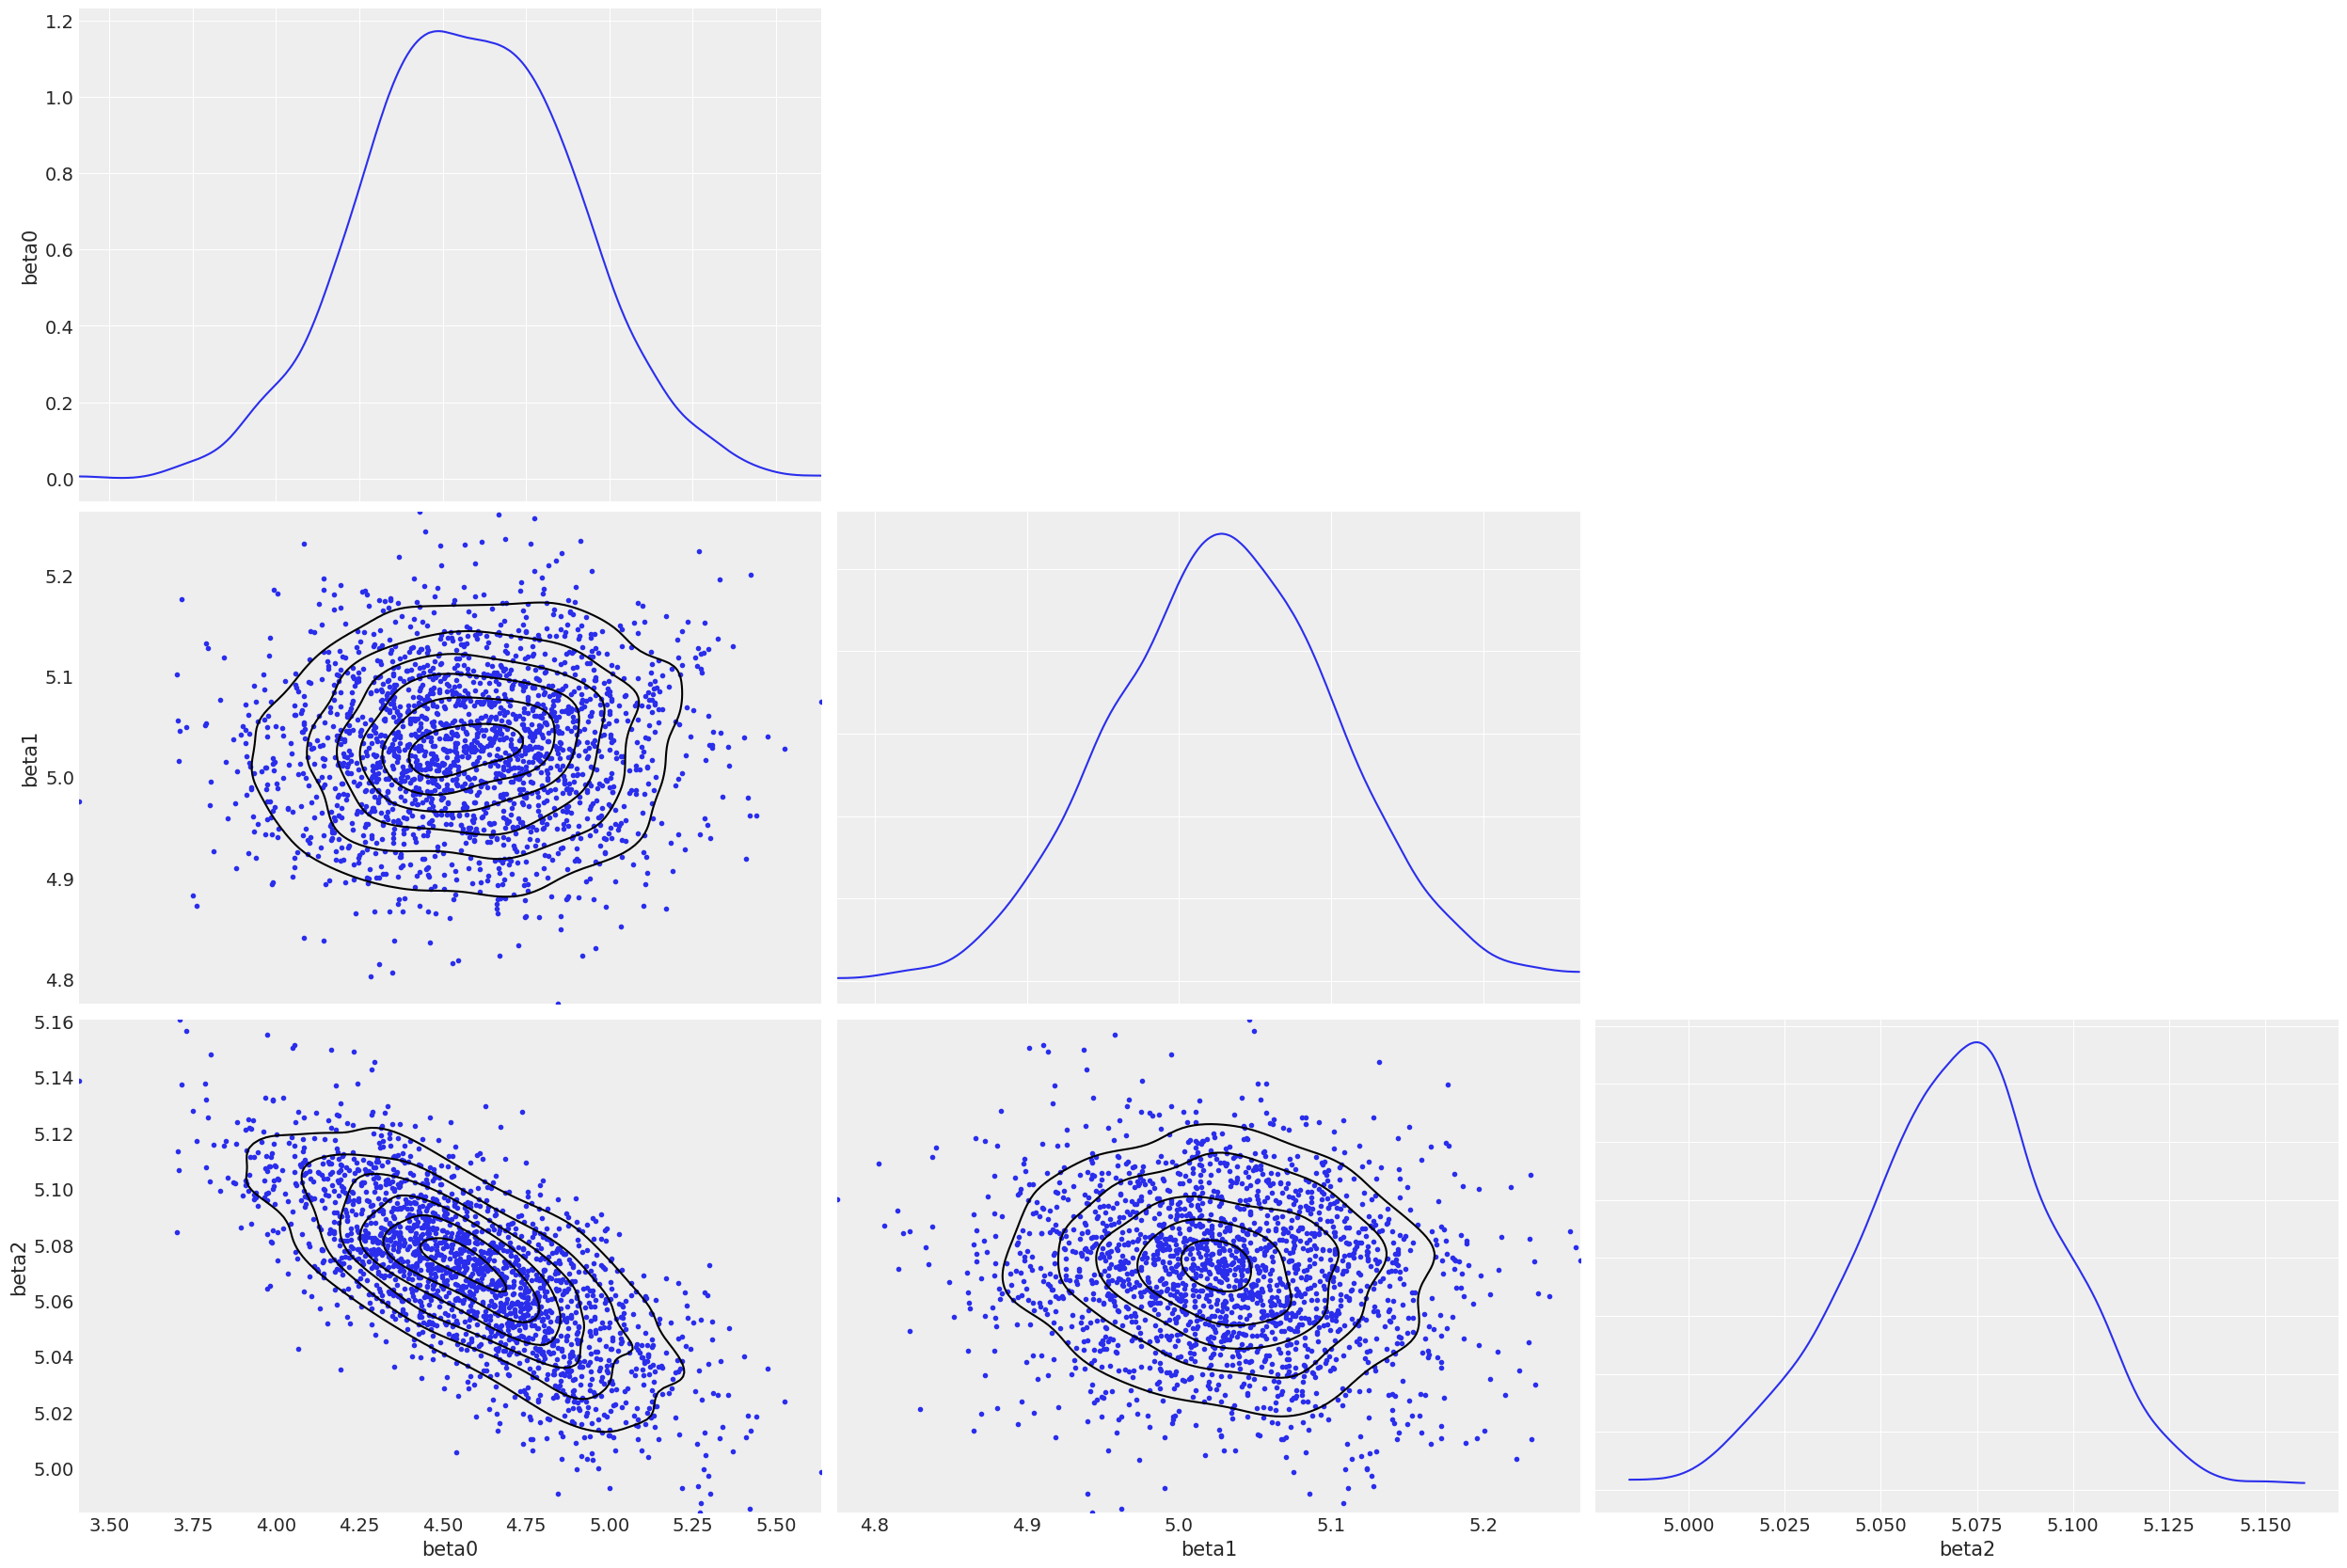

In [26]:
az.plot_pair(output2, var_names=['beta0', 'beta1', 'beta2'], 
             kind=["scatter", "kde"], marginals=True);

## Order 3 regression

In [27]:
order3_model = 'order3_model'
! cd $stan_directory/ && make $models_dirpath/$order3_model && cd $cwd


--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order3_model.hpp /home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order3_model.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order3_model.o /home/tng/Documents/PremiersEssais/RegressionExample/PolynomialReg/models/order3_model.hpp
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-igno

In [28]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=500
warm_iter=500

model=order3_model
data_input=poly_data_file/poly_data.json
data_output=output_${alg}_${model}

mkdir -p ./output/${data_output}


for i in `seq 4`
do
    ./models/$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=./${data_input}\
        output file=output/${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> output/${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [29]:
output_order3_dirname = 'output_hmc_' + order3_model
output_order3_dirpath = output_foldername + '/' + output_order3_dirname
order3_output_filename = 'output_hmc_order3_model_'

In [30]:
#wait and check: (Total)
time.sleep(5) #5 seconds sleep
!tail -n2 $output_order3_dirpath/*out

==> output/output_hmc_order3_model/output_hmc_order3_model_1.out <==
               0.686 seconds (Total)


==> output/output_hmc_order3_model/output_hmc_order3_model_2.out <==
               0.557 seconds (Total)


==> output/output_hmc_order3_model/output_hmc_order3_model_3.out <==
               0.561 seconds (Total)


==> output/output_hmc_order3_model/output_hmc_order3_model_4.out <==
               0.627 seconds (Total)



In [31]:
! $stan_directory/bin/stansummary $output_order3_dirpath/output_hmc_order3_model_*.csv

Inference for Stan model: order3_model_model
4 chains: each with iter=(500,500,500,500); warmup=(0,0,0,0); thin=(1,1,1,1); 2000 iterations saved.

Warmup took (0.39, 0.32, 0.32, 0.35) seconds, 1.4 seconds total
Sampling took (0.29, 0.24, 0.24, 0.28) seconds, 1.1 seconds total

                    Mean     MCSE  StdDev        5%       50%    95%    N_Eff  N_Eff/s    R_hat

lp__            -1.3e+02  5.7e-02     1.6  -1.4e+02  -1.3e+02   -131      758      722      1.0
accept_stat__       0.99  1.2e-03   0.016      0.96      1.00   1.00  1.8e+02  1.7e+02  1.0e+00
stepsize__          0.12  1.3e-02   0.018     0.097      0.14   0.14  2.0e+00  1.9e+00  6.0e+13
treedepth__          4.4  7.5e-02    0.73       3.0       5.0    5.0  9.5e+01  9.1e+01  1.0e+00
n_leapfrog__          30  2.6e+00      15       7.0        31     63  3.3e+01  3.2e+01  1.0e+00
divergent__         0.00      nan    0.00      0.00      0.00   0.00      nan      nan      nan
energy__             135  8.1e-02     2.2       1

In [32]:
#Load the cmdstanpy output as an arviz.InferenceData object
output3 = az.from_cmdstan(posterior=output_order3_dirpath + '/' + order3_output_filename + '*'  + '.csv',
                          posterior_predictive='y_rep',
                          observed_data=data_filepath, observed_data_var=['y'],
                          constant_data=data_filepath, constant_data_var=['t'])
output3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> constant_data

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/density_uti

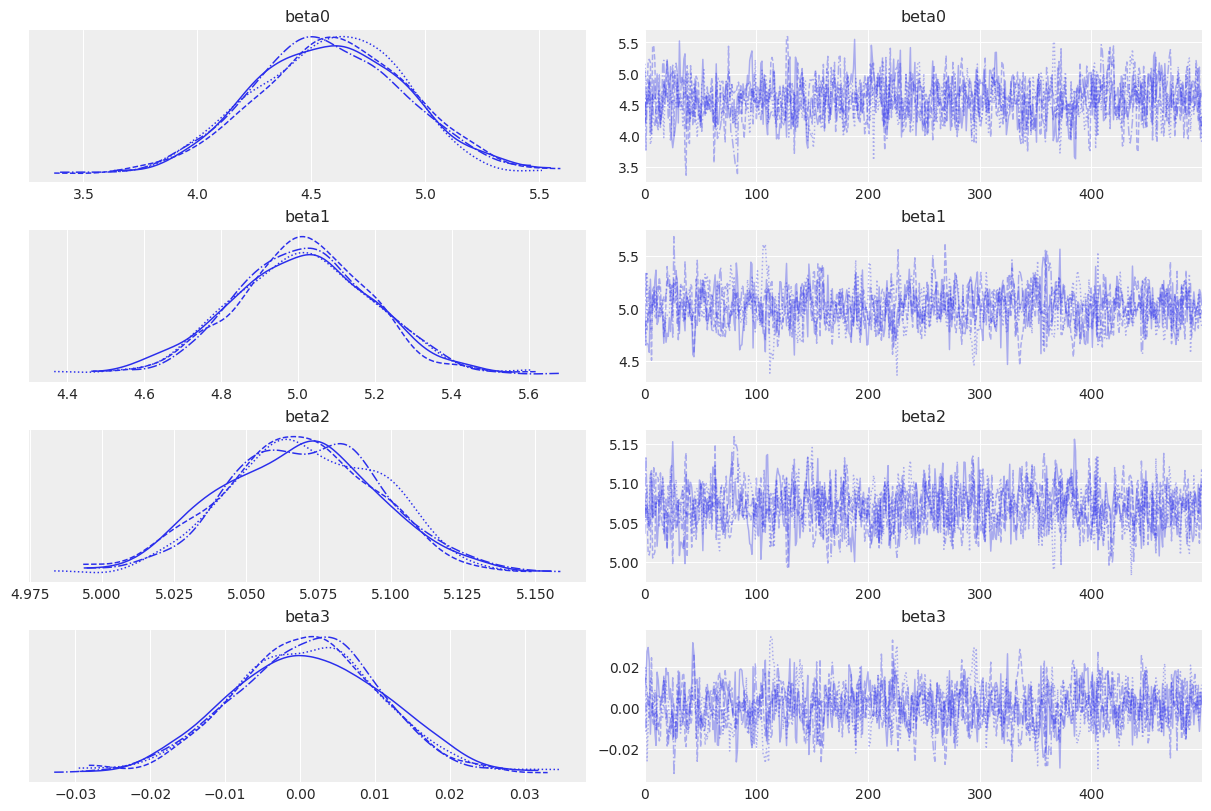

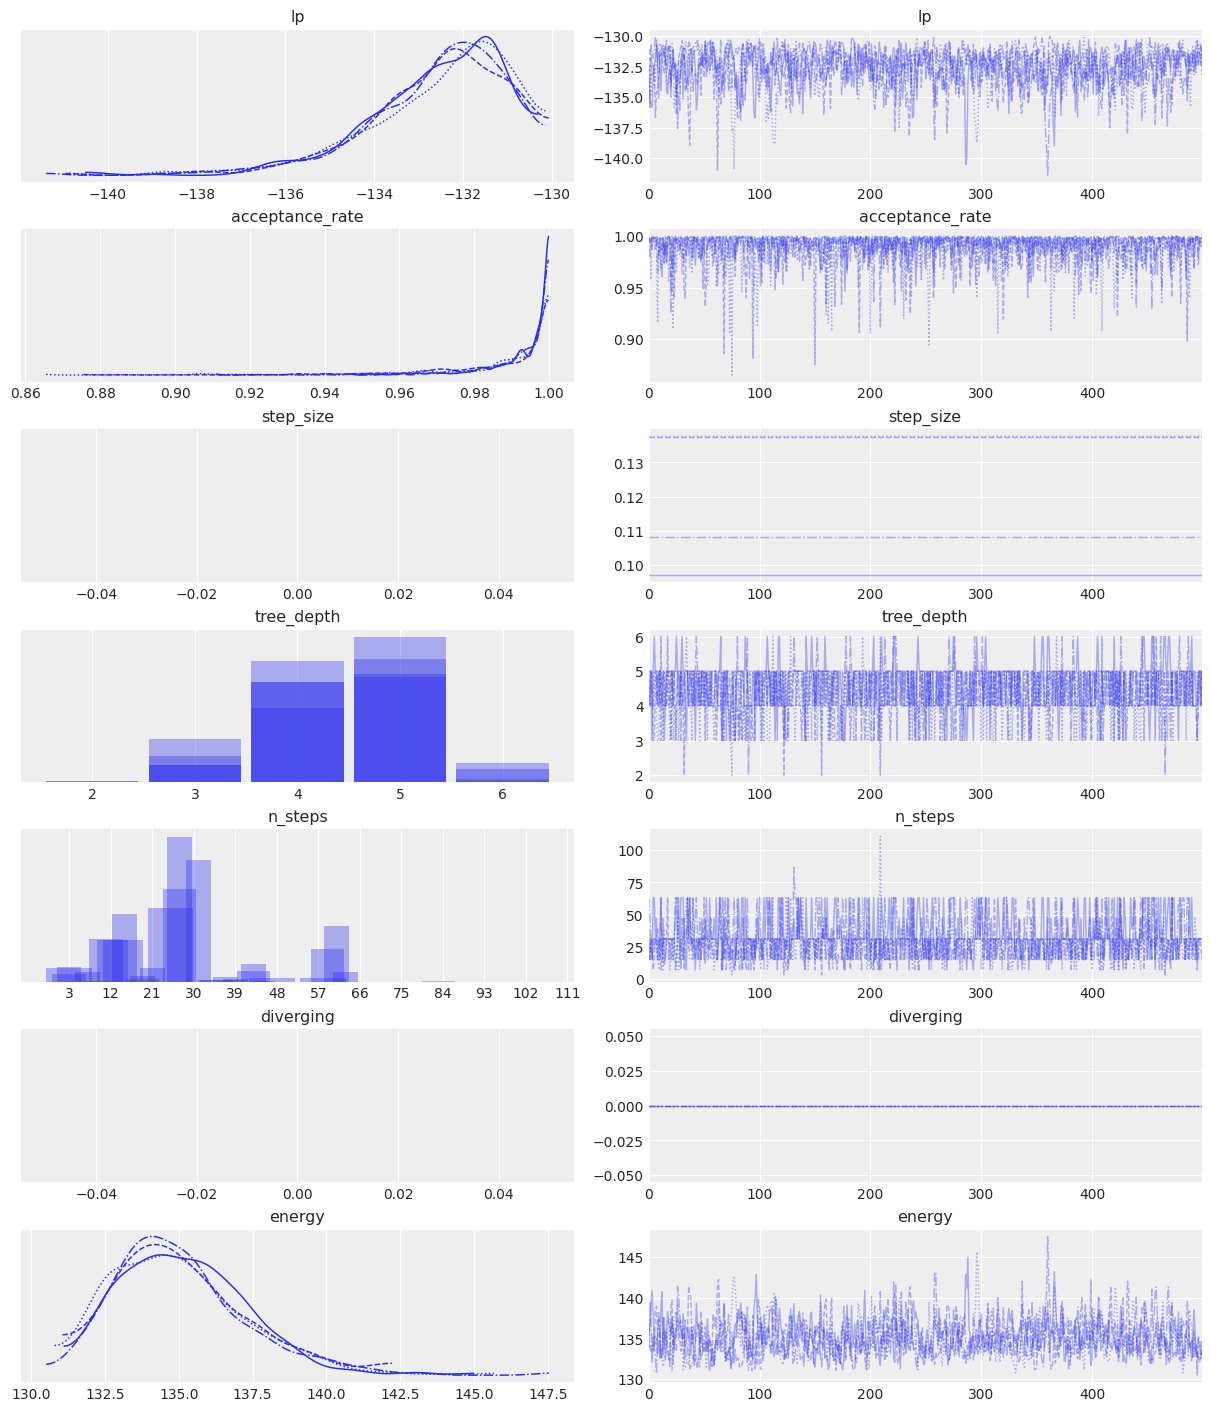

In [33]:
az.plot_trace(output3.posterior, var_names=['beta0', 'beta1', 'beta2', 'beta3']);
az.plot_trace(output3.sample_stats);

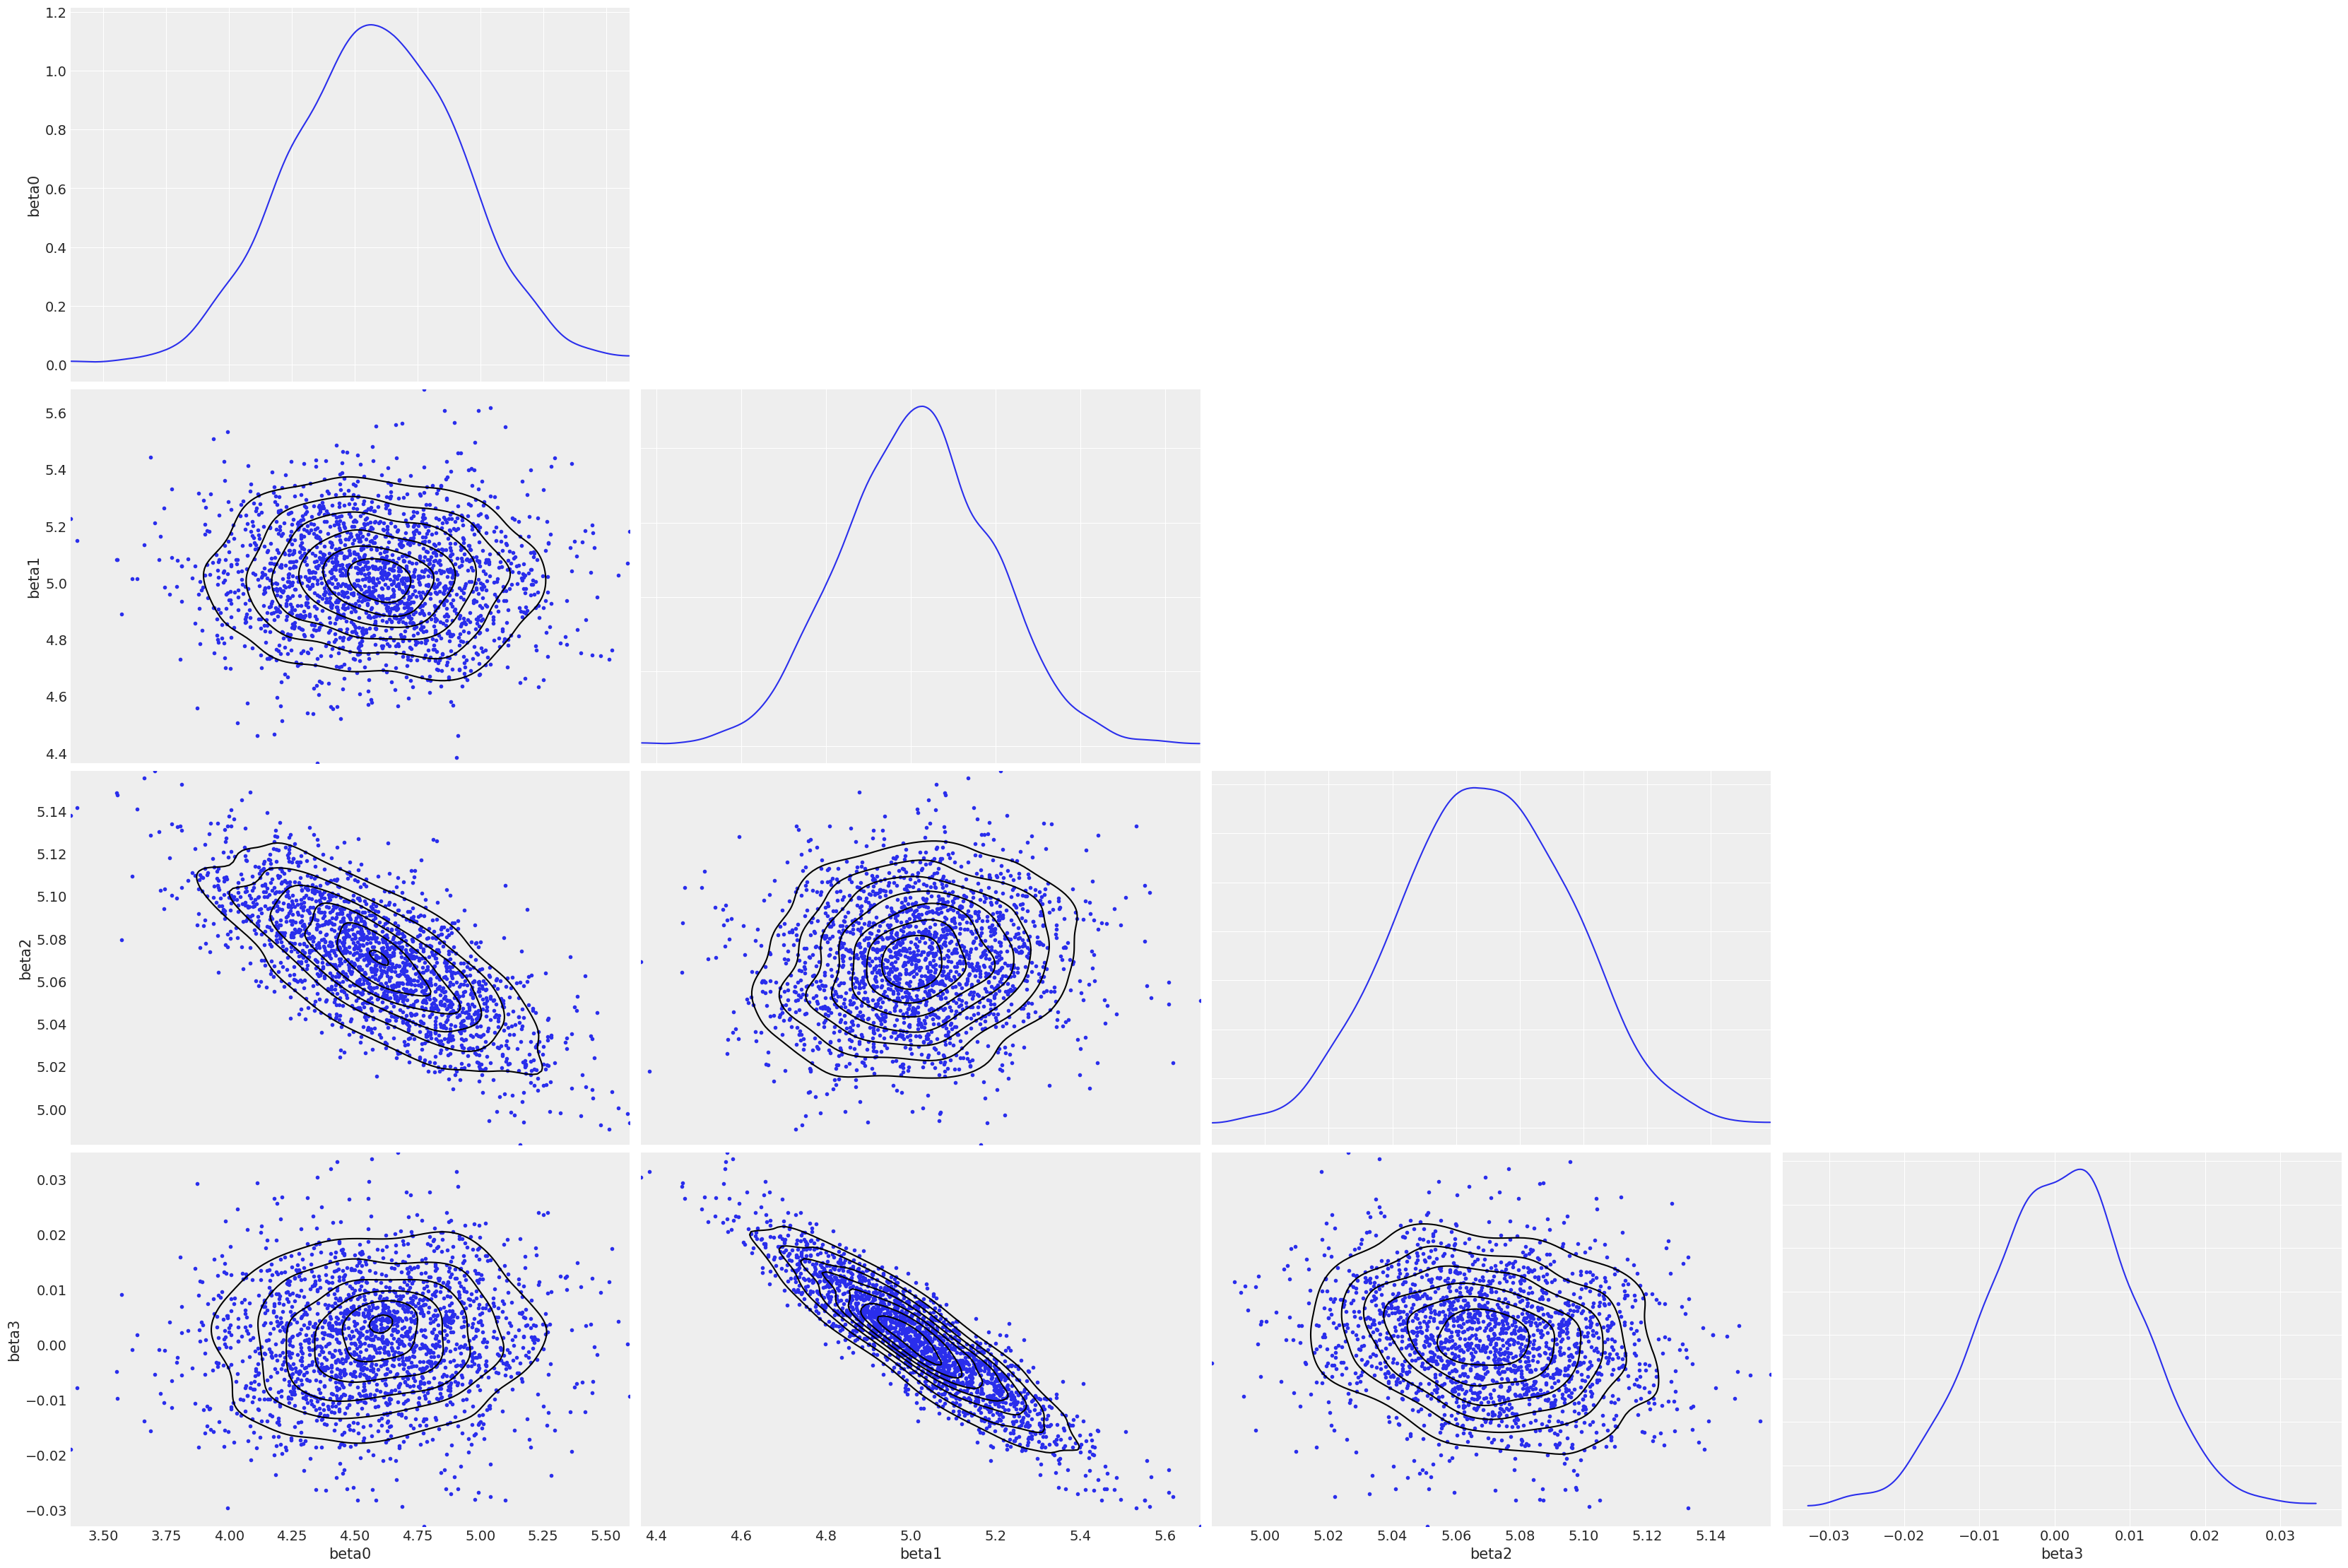

In [34]:
az.plot_pair(output3, var_names=['beta0', 'beta1', 'beta2', 'beta3'],
                kind=["scatter", "kde"], marginals=True);

(500, 102)


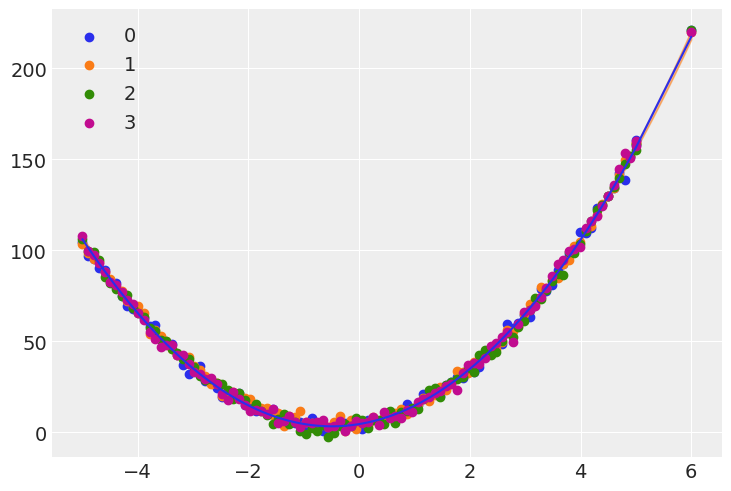

In [35]:
output3.posterior['y_model'] = output3.posterior['beta0'] + \
    output3.posterior['beta1'] * output3.constant_data['t'] + \
    output3.posterior['beta2'] * output3.constant_data['t']**2 + \
    output3.posterior['beta3'] * output3.constant_data['t']**3
mean_chain = output3.posterior['y_model'].mean(axis=0)
print(mean_chain.shape)
az.plot_hdi(x=output3.constant_data['t'], y=output3.posterior['y_model'], hdi_prob=0.95)
plt.plot(output3.constant_data['t'], mean_chain.mean(axis=0))

for ichain in range(4) :
    plt.scatter(output3.constant_data['t'], output3.posterior_predictive['y_rep'][ichain][0], label=str(ichain))
plt.legend()
plt.show()

## Information criterions

https://arxiv.org/pdf/1507.04544.pdf

In [36]:
def WAIC_LogLik(log_lik) :

    WAIC_arr = np.empty((log_lik.shape[0]))
    for ichain in range(log_lik.shape[0]) :
        waic = CIC.waic(log_lik[ichain])['waic']
        WAIC_arr[ichain] = waic
    WAIC_arr = np.array(WAIC_arr)
    return WAIC_arr.mean()

def compute_classical_IC(log_lik, nparams, ndata) :
    
    K = log_lik.shape[0]
    BIC_arr = np.empty((K))
    AIC_arr = np.empty((K))
    AICc_arr = np.empty((K))
    
    for ichain in range(K) :
        BIC_arr[ichain] = CIC.bic(log_lik[ichain], nparams, ndata)
        AIC_arr[ichain] = CIC.aic(log_lik[ichain], nparams)
        AICc_arr[ichain] = CIC.aicc(log_lik[ichain], nparams, ndata)
    BIC_arr = np.array(BIC_arr)
    AIC_arr = np.array(AIC_arr)
    out = {'bic': [BIC_arr.mean(), BIC_arr.std()], 'aic': [AIC_arr.mean(), AIC_arr.std()],
          'aicc': [AICc_arr.mean(), AICc_arr.std()]}
    return out

In [37]:
#Tests

log_lik1 = output1.log_likelihood['log_lik'].to_numpy()
#Homemade version of WAICWAIC_LogLik(log_lik1)
print('Fit 1 WAIC=', WAIC_LogLik(log_lik1))
#Arviz version of WAIC (deviance scale)
print(az.waic(data=output1, var_name='log_lik', scale='deviance'))

Fit 1 WAIC= 1055.063230144009
Computed from 2000 by 102 log-likelihood matrix

              Estimate       SE
deviance_waic  1055.07    13.27
p_waic            3.51        -

There has been a warning during the calculation. Please check the results.


/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [38]:
import ComputeInfoC as CIC
aic_fits = [] ; loo_fits = [] ; waic_fits = [] ; bic_fits=[] ; aicc_fits=[]
ic_all = []
for k_params, k_output in zip([2, 3, 4], [output1, output2, output3]) :
    ic = compute_classical_IC(k_output.log_likelihood['log_lik'].to_numpy(), k_params, nt_obs)
    ic_all.append(ic)
    aic_fits.append(ic['aic'])
    bic_fits.append(ic['bic'])
    aicc_fits.append(ic['aicc'])
    waic_fits.append(az.waic(k_output, var_name='log_lik', scale='deviance'))
    loo_fits.append(az.loo(k_output, var_name='log_lik', scale='deviance'))

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and h

In [39]:
ic_all

[{'bic': [18.155850626568544, 0.043980703439122804],
  'aic': [12.905905, 0.04398070343912216],
  'aicc': [13.027117121212122, 0.04398070343912216]},
 {'bic': [16.94947843985281, 0.03687721518770182],
  'aic': [9.07456, 0.03687721518770122],
  'aicc': [9.319457959183673, 0.03687721518770122]},
 {'bic': [21.54868625313708, 0.06785807450112401],
  'aic': [11.048795000000002, 0.06785807450112341],
  'aicc': [11.461166134020619, 0.06785807450112341]}]

In [40]:
loo_fits

[Computed from 2000 by 102 log-likelihood matrix
 
              Estimate       SE
 deviance_loo  1055.07    13.27
 p_loo            3.52        -
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      102  100.0%
  (0.5, 0.7]   (ok)          0    0.0%
    (0.7, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    0    0.0%,
 Computed from 2000 by 102 log-likelihood matrix
 
              Estimate       SE
 deviance_loo   485.44    97.96
 p_loo           25.88        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      100   98.0%
  (0.5, 0.7]   (ok)          1    1.0%
    (0.7, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    1    1.0%,
 Computed from 2000 by 102 log-likelihood matrix
 
              Estimate       SE
 deviance_loo   489.22    96.69
 p_loo           28.38        -
 
 There ha

In [41]:
waic_fits

[Computed from 2000 by 102 log-likelihood matrix
 
               Estimate       SE
 deviance_waic  1055.07    13.27
 p_waic            3.51        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 2000 by 102 log-likelihood matrix
 
               Estimate       SE
 deviance_waic   498.24   110.58
 p_waic           32.28        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 2000 by 102 log-likelihood matrix
 
               Estimate       SE
 deviance_waic   502.32   110.19
 p_waic           34.93        -
 
 There has been a warning during the calculation. Please check the results.]

In [42]:
aic_values = np.array(aic_fits)[:, 0]
aic_sd = np.array(aic_fits)[:, 1]
aicc_values = np.array(aicc_fits)[:, 0]
aicc_sd = np.array(aicc_fits)[:, 1]
bic_values = np.array(bic_fits)[:, 0]
bic_sd = np.array(bic_fits)[:, 1]
waic_values = np.array(waic_fits)[:, 0]
waic_se = np.array(waic_fits)[:, 1]
loo_values = np.array(loo_fits)[:, 0]
loo_se = np.array(loo_fits)[:, 1]
paic_values = np.array(waic_fits)[:, 2] 

In [43]:
print('Best model aic:', np.argmin(aic_values) + 1)
print('Best model bic:', np.argmin(bic_values) + 1)
print('Best model aicc:', np.argmin(aicc_values) + 1)
print('Best model waic:', np.argmin(waic_values) + 1)
print('Best model loo:', np.argmin(loo_values) + 1)

Best model aic: 2
Best model bic: 2
Best model aicc: 2
Best model waic: 2
Best model loo: 2


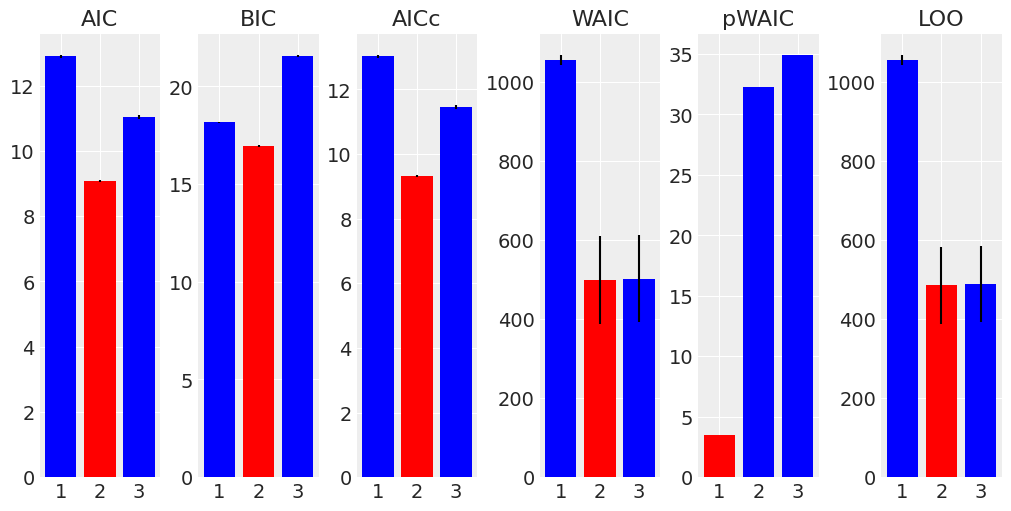

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))

colors = ['blue', 'red']

#estimated number of effective parameters

x = range(1, 4)
col = np.array((waic_values == np.min(waic_values)), dtype='int')

ax[0].bar(x, aic_values, yerr=aic_sd,
        color=[colors[1] if i == np.argmin(aic_values) else colors[0] for i in range(len(aic_values))])
ax[1].bar(x, bic_values, yerr=bic_sd,
        color=[colors[1] if i == np.argmin(bic_values) else colors[0] for i in range(len(bic_values))])
ax[2].bar(x, aicc_values, yerr=aicc_sd,
        color=[colors[1] if i == np.argmin(aicc_values) else colors[0] for i in range(len(aicc_values))])
ax[3].bar(x, waic_values, yerr=waic_se,
        color=[colors[1] if i == np.argmin(waic_values) else colors[0] for i in range(len(waic_values))])
ax[4].bar(x, paic_values,
        color=[colors[1] if i == np.argmin(paic_values) else colors[0] for i in range(len(paic_values))])
ax[5].bar(x, loo_values, yerr=loo_se,
        color=[colors[1] if i == np.argmin(loo_values) else colors[0] for i in range(len(loo_values))])
ax[0].set(title='AIC')
ax[1].set(title='BIC')
ax[2].set(title='AICc')
ax[3].set(title='WAIC')
ax[4].set(title='pWAIC')
ax[5].set(title='LOO')

plt.show()

**WAIC approches LOO**

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWa

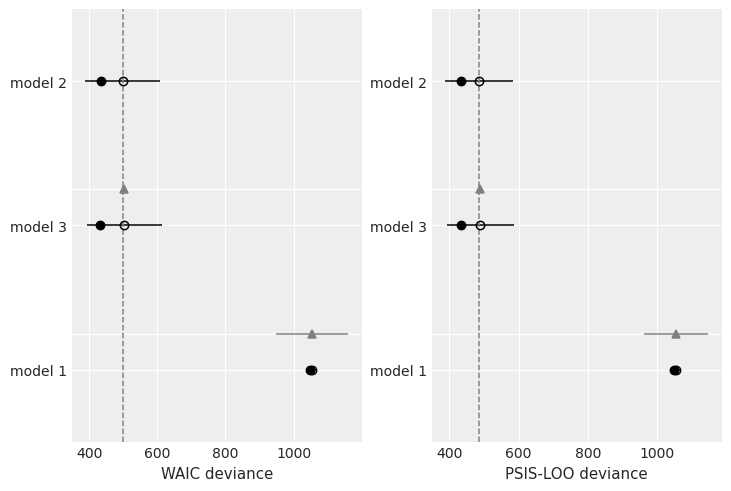

In [45]:
compare_loo = az.compare({'model 1': output1, 'model 2': output2, 'model 3': output3}, 
                         scale='deviance')
compare_waic = az.compare({'model 1': output1, 'model 2': output2, 'model 3': output3}, 
                         ic='waic',
                         scale='deviance')
fig, ax = plt.subplots(ncols=2)
az.plot_compare(compare_waic, ax=ax[0])
ax[0].set(xlabel='WAIC deviance')
az.plot_compare(compare_loo, ax=ax[1])
ax[1].set(xlabel='PSIS-LOO deviance')
plt.show()

In [46]:
models = [output2, output3]
waic_subiters = [[], [], []]
loo_subiters = [[], [], []]
for imodel in range(len(models)) :
    for ndraws in range(10, 501, 10) :
        subiters = models[imodel].sel(draw=[i for i in range(ndraws)])
        waic_subiters[imodel].append(az.waic(subiters, var_name='log_lik', scale='deviance')[0])
        loo_subiters[imodel].append(az.loo(subiters, var_name='log_lik', scale='deviance')[0])

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because impo

/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/tng/.local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv

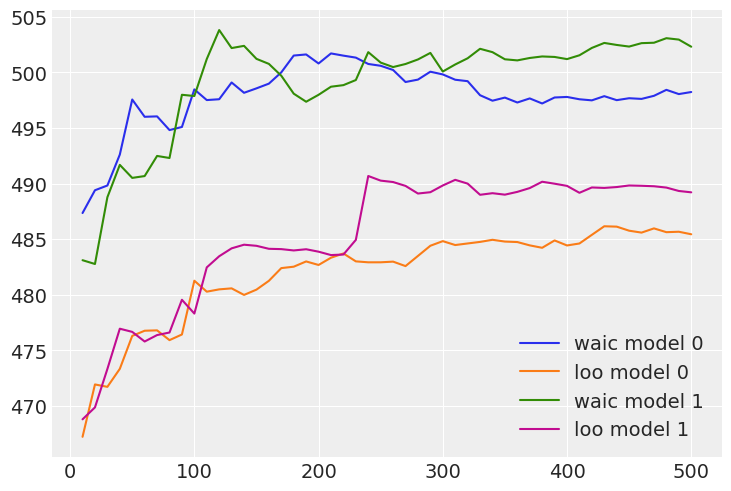

In [47]:
for imodel in range(2) :
    plt.plot(range(10, 501, 10), waic_subiters[imodel], label='waic model ' + str(imodel))
    plt.plot(range(10, 501, 10), loo_subiters[imodel], label='loo model ' + str(imodel))
plt.legend()
plt.show()